### Analysis of PTZ protocol for susceptibility to epileptic seizures

In [285]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pingouin as pg
import numpy as np
from matplotlib.colors import ListedColormap
from scipy.stats import fisher_exact
from sklearn.utils import resample
from scipy.stats import binom_test

In [302]:
ptz_raw = pd.read_csv('/Users/labc02/Documents/PDCB_data/MK-project/PTZ_protocol.csv')

In [303]:
ptz_raw

,ID,Sex,Genotype,Tx,Weight,0 mg/kg,20 mg/kg,40 mg/kg,60 mg/kg,80 mg/kg,Fatalities,CoD
0,WT_8.4.9,Female,WT,Pl,22.85,0,1,5,5,5,0,NaN
1,KO_8.5.1,Female,KO,MK-0.5,27.05,0,5,5,5,7,1,RA
2,KO_8.5.2,Female,KO,MK-0.5,25.12,0,2,5,5,5,0,NaN
3,WT_6.6.5,Female,WT,Pl,28.36,0,2,5,6,6,0,NaN
4,WT_6.6.1,Female,WT,MK-0.5,26.43,0,1,3,5,7,1,RA
5,KO_7.5.2,Female,KO,Pl,23.52,1,5,5,5,5,0,NaN
6,KO_7.4.5,Female,KO,Pl,25.90,0,4,5,6,6,0,NaN
7,WT_9.9.1,Female,WT,MK-1,20.15,0,3,5,5,5,0,NaN
8,KO_7.7.3,Male,KO,Pl,30.05,0,4,5,5,5,0,NaN
9,WT_9.10.2,Male,WT,MK-0.5,28.93,0,1,5,5,7,1,RA


In [304]:
rename_dic = {}
for col in range(5, 10):
    name = ptz_raw.columns[col]
    new_name = name.split()[0]
    rename_dic[name] = int(new_name)

In [305]:
ptz_raw.rename(columns= rename_dic, inplace = True)

In [306]:
ptz_raw

,ID,Sex,Genotype,Tx,Weight,0,20,40,60,80,Fatalities,CoD
0,WT_8.4.9,Female,WT,Pl,22.85,0,1,5,5,5,0,NaN
1,KO_8.5.1,Female,KO,MK-0.5,27.05,0,5,5,5,7,1,RA
2,KO_8.5.2,Female,KO,MK-0.5,25.12,0,2,5,5,5,0,NaN
3,WT_6.6.5,Female,WT,Pl,28.36,0,2,5,6,6,0,NaN
4,WT_6.6.1,Female,WT,MK-0.5,26.43,0,1,3,5,7,1,RA
5,KO_7.5.2,Female,KO,Pl,23.52,1,5,5,5,5,0,NaN
6,KO_7.4.5,Female,KO,Pl,25.90,0,4,5,6,6,0,NaN
7,WT_9.9.1,Female,WT,MK-1,20.15,0,3,5,5,5,0,NaN
8,KO_7.7.3,Male,KO,Pl,30.05,0,4,5,5,5,0,NaN
9,WT_9.10.2,Male,WT,MK-0.5,28.93,0,1,5,5,7,1,RA


In [307]:
ptz_scale = ptz_raw.drop(['Fatalities', 'CoD'], axis = 1) # Selecting columns with seizure severity

In [308]:
ptz_mort = ptz_raw.drop(ptz_raw.columns[[5, 6, 7, 8, 9]], axis = 1) # Selecting columns of fatalilties

In [309]:
ptz_scale = pd.melt(ptz_scale, id_vars=['ID', 'Sex', 'Genotype', 'Tx', 'Weight'], value_vars = [0, 20, 40, 60, 80], var_name = 'Dose', value_name = 'Severity')


In [310]:
ptz_scale

,ID,Sex,Genotype,Tx,Weight,Dose,Severity
0,WT_8.4.9,Female,WT,Pl,22.85,0,0
1,KO_8.5.1,Female,KO,MK-0.5,27.05,0,0
2,KO_8.5.2,Female,KO,MK-0.5,25.12,0,0
3,WT_6.6.5,Female,WT,Pl,28.36,0,0
4,WT_6.6.1,Female,WT,MK-0.5,26.43,0,0
...,...,...,...,...,...,...,...
255,WT_6.11.2,Male,WT,MK-1,25.41,80,6
256,WT_9.14.1,Male,WT,MK-1,25.62,80,5
257,WT_12.2.2,Male,WT,MK-1,24.55,80,5
258,WT_6.11.3,Female,WT,MK-0.5,24.50,80,7


In [312]:
ptz_mort_sum = ptz_mort.groupby(['Genotype', 'Tx'])['Fatalities'].sum()

Text(0.84, 0.3, '10')

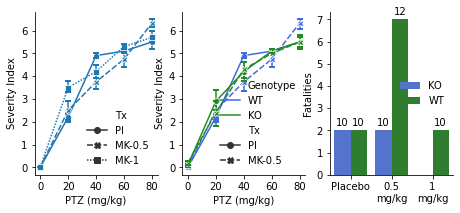

In [331]:
plt.figure(figsize = (7.5, 3))
ax_1 = plt.subplot(131)
sns.lineplot(data = ptz_scale[ptz_scale['Genotype'] == 'WT'], x = 'Dose', y= 'Severity', style = 'Tx', markers =True, palette= ['royalblue'], err_style = 'bars', ci = 68, err_kws={'capsize': 3, 'capthick':2}, legend='brief', ax = ax_1)
sns.despine()
ax_1.set_ylabel('Severity Index')
ax_1.set_xlabel('PTZ (mg/kg)')
ax_1.set_xticks([0, 20, 40, 60, 80])
ax_1.legend(ncol = 1, frameon = False)
ax_2 = plt.subplot(132)
sns.lineplot(data = ptz_scale[ptz_scale['Tx']!='MK-1'], x = 'Dose', y= 'Severity', hue = 'Genotype', style = 'Tx', markers =True, palette= ['royalblue', 'forestgreen'], err_style = 'bars', ci = 68, err_kws={'capsize': 3, 'capthick':2}, legend='brief', ax = ax_2)
sns.despine()
ax_2.set_ylabel('Severity Index')
ax_2.set_xlabel('PTZ (mg/kg)')
ax_2.set_xticks([0, 20, 40, 60, 80])
ax_2.legend(ncol = 1, frameon = False)
ax_3 = plt.subplot(133)
sns.barplot(data = ptz_mort_sum.reset_index(name = 'Fatalities'), x = 'Tx', y = 'Fatalities', hue = 'Genotype', order = ['Pl', 'MK-0.5', 'MK-1'], palette= ['royalblue', 'forestgreen'], ax = ax_3)
sns.despine()
ax_3.set_xticklabels(['Placebo', '0.5\nmg/kg', '1\nmg/kg'])
ax_3.set_xlabel('')
ax_3.legend(frameon = False, loc =7)
ax_3.annotate('10', xy =(.05, .3), xytext = (.05, .3), xycoords = 'axes fraction')
ax_3.annotate('10', xy =(.18, .3), xytext = (.18, .3), xycoords = 'axes fraction')
ax_3.annotate('10', xy =(.38, .3), xytext = (.38, .3), xycoords = 'axes fraction')
ax_3.annotate('12', xy =(.52, .98), xytext = (.52, .98), xycoords = 'axes fraction')
ax_3.annotate('10', xy =(.84, .3), xytext = (.84, .3), xycoords = 'axes fraction')


In [134]:
ptz_scale['Group'] = ptz_scale['Genotype'] + '_' + ptz_scale['Tx']

In [135]:
pg.mixed_anova(data = ptz_scale, dv = 'Severity', within = 'Dose', between = 'Group', subject = 'ID')

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,Group,4.753958,4,43,1.188490,0.834777,5.106333e-01,NaN,0.072058,NaN,NaN,NaN,NaN
1,Dose,969.277083,4,172,242.319271,324.680808,5.419385e-79,1.540344e-57,0.883051,0.70347,False,0.372112,9.829772e-07
2,Interaction,22.454028,16,172,1.403377,1.880368,2.510870e-02,NaN,0.148877,NaN,NaN,NaN,NaN


In [140]:
ph_df = pg.pairwise_ttests(data = ptz_scale, dv = 'Severity', within = 'Dose', between = 'Group', subject = 'ID')

/opt/miniconda3/envs/databs/lib/python3.8/site-packages/pingouin/effsize.py:728: RuntimeWarning: invalid value encountered in double_scalars
  d = (x.mean() - y.mean()) / poolsd


In [150]:
p_vals = ph_df.tail(50)

In [156]:
adj = pg.multicomp(p_vals['p-unc'].values)

In [158]:
p_vals['p-adjust'] = adj[1]

<ipython-input-158-c182f3bd275c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_vals['p-adjust'] = adj[1]


In [159]:
p_vals

,Contrast,Dose,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges,p-adjust
20,Dose * Group,0,WT_Pl,KO_MK-0.5,False,True,-1.500000,18.0,two-sided,0.150950,0.857,-0.642476,1.000000
21,Dose * Group,0,WT_Pl,WT_MK-0.5,False,True,NaN,18.0,two-sided,NaN,nan,NaN,NaN
22,Dose * Group,0,WT_Pl,KO_Pl,False,True,-1.000000,18.0,two-sided,0.330565,0.564,-0.428317,1.000000
23,Dose * Group,0,WT_Pl,WT_MK-1,False,True,NaN,18.0,two-sided,NaN,nan,NaN,NaN
24,Dose * Group,0,KO_MK-0.5,WT_MK-0.5,False,True,1.500000,18.0,two-sided,0.150950,0.857,0.642476,1.000000
25,Dose * Group,0,KO_MK-0.5,KO_Pl,False,True,0.600000,18.0,two-sided,0.555985,0.451,0.256990,1.000000
26,Dose * Group,0,KO_MK-0.5,WT_MK-1,False,True,1.500000,18.0,two-sided,0.150950,0.857,0.642476,1.000000
27,Dose * Group,0,WT_MK-0.5,KO_Pl,False,True,-1.000000,18.0,two-sided,0.330565,0.564,-0.428317,1.000000
28,Dose * Group,0,WT_MK-0.5,WT_MK-1,False,True,NaN,18.0,two-sided,NaN,nan,NaN,NaN
29,Dose * Group,0,KO_Pl,WT_MK-1,False,True,1.000000,18.0,two-sided,0.330565,0.564,0.428317,1.000000


In [179]:
# Pairwise Fisher exact tests
fisher_exact([[2, 8], [5, 5]], alternative = 'less')

(0.25, 0.17492260061919482)

In [201]:
# each group dichotomous results of fatalities as individual arrays

wt_pl = ptz_mort[(ptz_mort['Genotype']=='WT') & (ptz_mort['Tx'] == 'Pl')]['Fatalities'].values
wt_05 = ptz_mort[(ptz_mort['Genotype']=='WT') & (ptz_mort['Tx'] == 'MK-0.5')]['Fatalities'].values
wt_1 = ptz_mort[(ptz_mort['Genotype']=='WT') & (ptz_mort['Tx'] == 'MK-1')]['Fatalities'].values
ko_pl = ptz_mort[(ptz_mort['Genotype']=='KO') & (ptz_mort['Tx'] == 'Pl')]['Fatalities'].values
ko_05 = ptz_mort[(ptz_mort['Genotype']=='KO') & (ptz_mort['Tx'] == 'MK-0.5')]['Fatalities'].values

In [272]:
# simulate new experiments in a perfect scenario
n_wtpl = np.append(wt_pl, [0,0,0,0])
n_wt05 = np.append(wt_05, [1,1,1,1])
n_wt1 = np.append(wt_1, [0,0,0,0])
n_kopl = np.append(ko_pl, [0,0,0,0])
n_ko05 = np.append(ko_05, [0,0,0,0])

In [273]:
# generate bootstrap samples
BN = 10000

plzip = np.array(list(zip(n_wtpl, n_wt05, n_wt1, n_kopl, n_ko05)))
bs_samps = np.zeros((BN, plzip.shape[0], plzip.shape[1]))
for i in range(BN):
    bs_samps[i,] = resample(plzip, replace = True)


In [274]:
print(bs_samps.shape)

(10000, 14, 5)


In [275]:
bs_dist = bs_samps.sum(axis = 1)/bs_samps.shape[1]

In [276]:
bs_dist.shape

(10000, 5)

In [277]:
print(np.percentile(bs_dist[:,0], (2.5, 97.5)))
print(np.percentile(bs_dist[:,1], (2.5, 97.5)))

[0.         0.35714286]
[0.35714286 0.85714286]


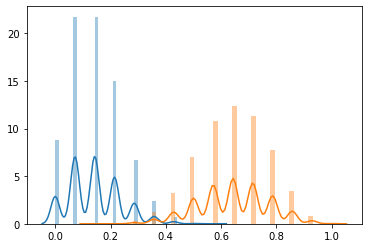

In [278]:
sns.distplot(bs_dist[:,0])
sns.distplot(bs_dist[:,1])

In [279]:
bs_diff = bs_dist[:,0] - bs_dist[:,1]

In [290]:
np.percentile(bs_dist[:,0], (2.5, 97.5))

array([0.        , 0.35714286])

In [297]:
pg.multicomp([0.0039, 0.99, 0.99, 0.99], method= 'holm')

(array([ True, False, False, False]), array([0.0156, 1.    , 1.    , 1.    ]))

In [293]:
binom_test([7,5], p=0.2)

0.0039031316480000037